In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt

mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [2]:
resolution = 20

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [-1.5, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

design_region_resolution = 10
Nx = design_region_resolution + 1
Ny = design_region_resolution + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
)


geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

TE_top = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE_top]


def J(alpha):
    return npa.abs(alpha) ** 2


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

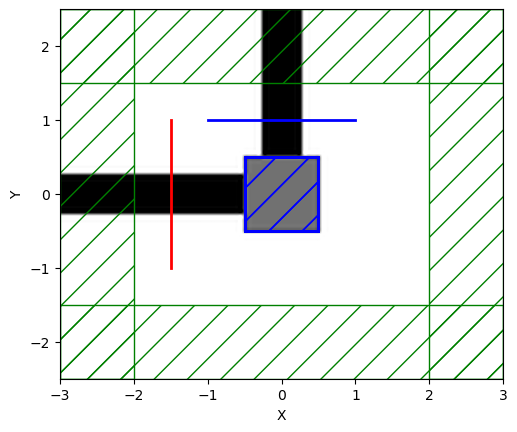

In [3]:
x0 = 0.5 * np.ones((Nx * Ny,))
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [4]:
evaluation_history = []
sensitivity = [0]


def f(x, grad):
    f0, dJ_du = opt([x])
    f0 = f0[0]  # f0 is an array of length 1
    if grad.size > 0:
        grad[:] = np.squeeze(dJ_du)
    evaluation_history.append(np.real(f0))
    sensitivity[0] = dJ_du
    return np.real(f0)

In [5]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 10

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)

In [6]:
x = solver.optimize(x0);

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


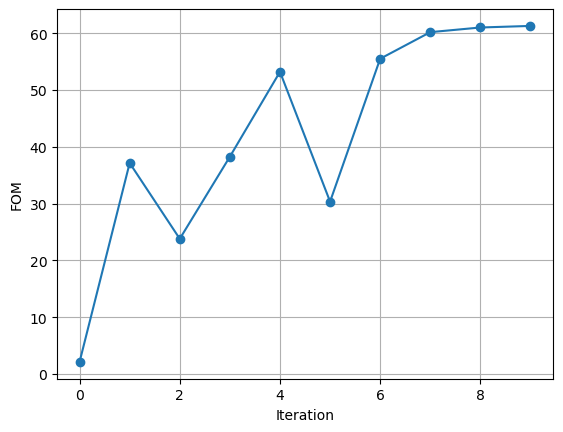

In [7]:
plt.figure()
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

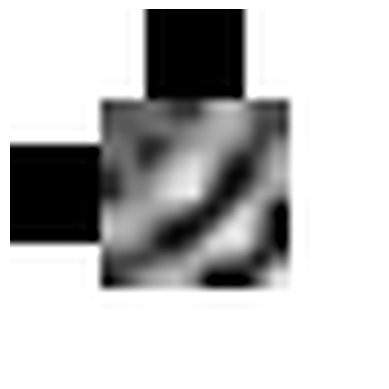

In [8]:
opt.update_design([x])
opt.plot2D(
    True,
    plot_monitors_flag=False,
    output_plane=mp.Volume(center=(0, 0, 0), size=(2, 2, 0)),
)
plt.axis("off");

In [9]:
TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(-1, 0, 0), size=mp.Vector3(y=2)), mode=1
)
ob_list = [TE0, TE_top]


def J(source, top):
    return npa.abs(top / source) ** 2


opt.objective_functions = [J]
opt.objective_arguments = ob_list
opt.update_design([x0])

In [10]:
evaluation_history = []
solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(x0)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


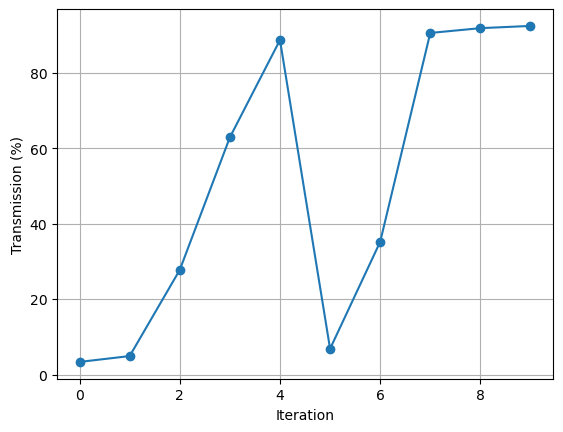

In [11]:
plt.figure()
plt.plot(np.array(evaluation_history) * 100, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Transmission (%)")
plt.show()

In [12]:
improvement = max(evaluation_history) / min(evaluation_history)
print("Achieved an improvement of {0:1.1f}x".format(improvement))

Achieved an improvement of 27.6x


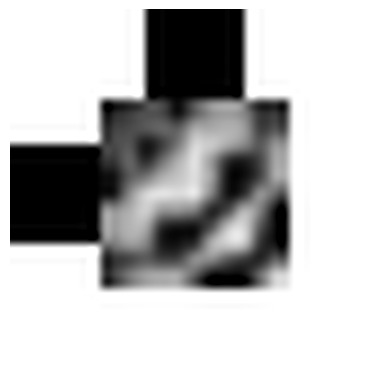

In [13]:
opt.update_design([x])
opt.plot2D(
    True,
    plot_monitors_flag=False,
    output_plane=mp.Volume(center=(0, 0, 0), size=(2, 2, 0)),
)
plt.axis("off");

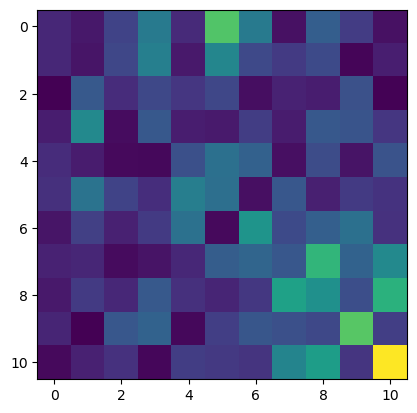

In [14]:
plt.imshow(np.rot90(np.squeeze(np.abs(sensitivity[0].reshape(Nx, Ny)))));
